In [5]:
%load_ext autoreload
%autoreload 2

In [44]:
import sys
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint

# time series specific
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.performance_metrics.forecasting import (
    # functions
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    mean_squared_error,
    mean_squared_scaled_error,
    # classes
    MeanAbsoluteError,
    MeanAbsolutePercentageError,
    MeanAbsoluteScaledError,
    MeanSquaredError,
    MeanSquaredScaledError,
)

from dsf_utils.preprocessing import process_raw_data, single_region_ts
# custom model from:
# https://www.sktime.org/en/latest/developer_guide/add_estimators
from dsf_utils.models import ConstantValueForecaster

# warnings
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (20,10)})
# set the numpy seed
np.random.seed(99)

## Synthetic Data

In [7]:
synthetic_data = pd.Series(
    10 + np.random.lognormal(5, 1, 365),
    index = pd.PeriodIndex(pd.date_range(start="2020-01-01", freq="D", periods=365), freq="D"), 
)

# quick and dirty
lognormal_mean = lambda m, s: np.exp(m+((s**2)/2))
lognormal_median = lambda m: np.exp(m)

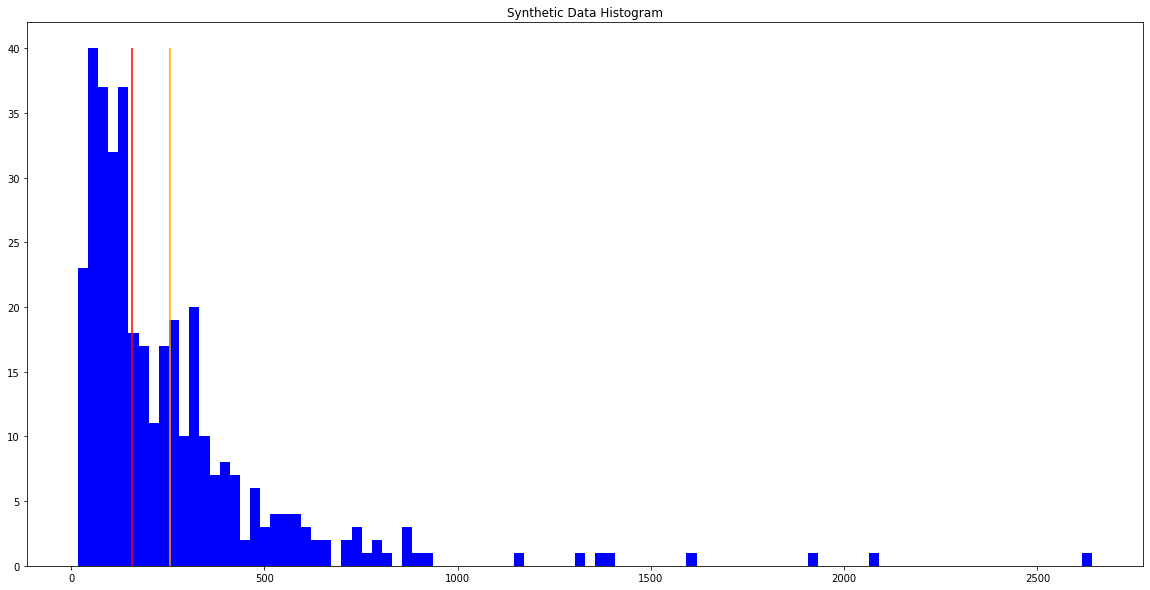

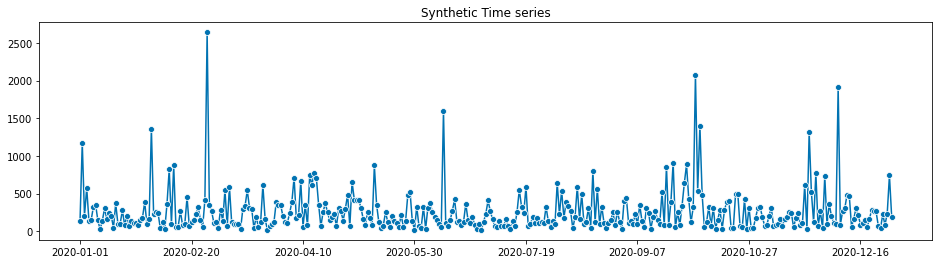

In [8]:
plt.hist(synthetic_data, color='blue', bins=100)
plt.vlines(10+lognormal_median(5), ymin=0, ymax=40, color="red")
plt.vlines(10+lognormal_mean(5, 1), ymin=0, ymax=40, color="orange")
plt.title("Synthetic Data Histogram")
plt.show()

plot_series(synthetic_data)
plt.title("Synthetic Time series")
plt.show()

## California ILI total

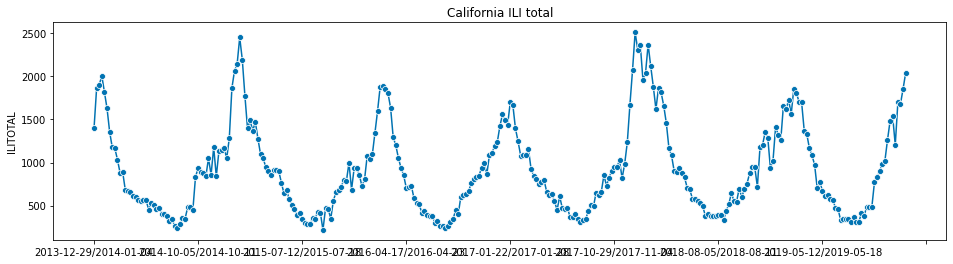

In [33]:
# California time series
main_df = pd.read_csv("../DATA/ILINet.csv", na_values="X")
main_df = process_raw_data(main_df)
real_ts = single_region_ts(main_df, region="California")
plot_series(real_ts)
plt.title("California ILI total")
plt.show()

## Naive forecasting methods

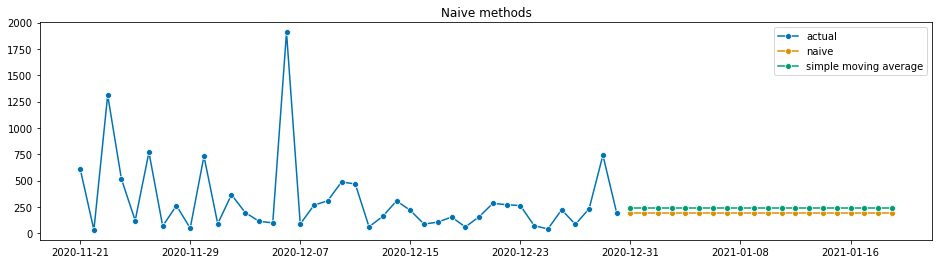

In [41]:
naive_fcaster = NaiveForecaster(strategy="last", sp=1)
sma_fcaster = NaiveForecaster(strategy="mean", sp=1, window_length=10)
naive_fcaster.fit(synthetic_data)
sma_fcaster.fit(synthetic_data)
# true_median_fcaster = ConstantValueForecaster(constant=10+lognormal_median(5))
# true_mean_fcaster = ConstantValueForecaster(constant=10+lognormal_mean(5,1))

# true_median_fcaster.fit(synthetic_data)
# true_mean_fcaster.fit(synthetic_data)
fh = np.arange(20)+1
plot_series(
    synthetic_data.iloc[-40:],
    naive_fcaster.predict(fh),
    sma_fcaster.predict(fh),
#     true_median_fcaster.predict(fh),
#     true_mean_fcaster.predict(fh),
    labels = ["actual", "naive", "simple moving average"]
)
plt.title("Naive methods")
plt.show()

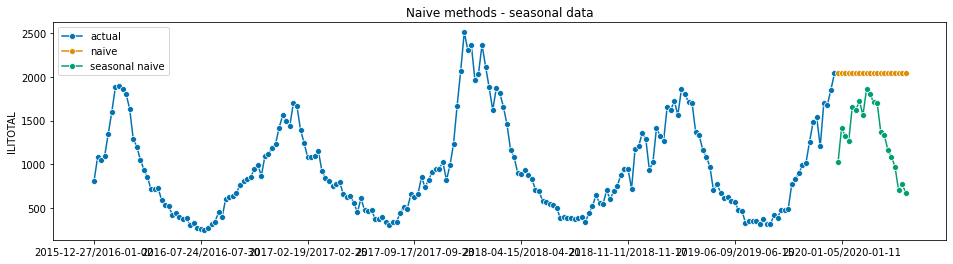

In [42]:
naive_fcaster = NaiveForecaster(strategy="last", sp=1)
seasonal_naive_fcaster = NaiveForecaster(strategy="last", sp=52)
naive_fcaster.fit(real_ts)
seasonal_naive_fcaster.fit(real_ts)
fh = np.arange(20)+104
plot_series(
    real_ts.iloc[104:],
    naive_fcaster.predict(fh),
    seasonal_naive_fcaster.predict(fh),
    labels = ["actual", "naive", "seasonal naive"]
)
plt.title("Naive methods - seasonal data")
plt.show()

## Evaluating performance

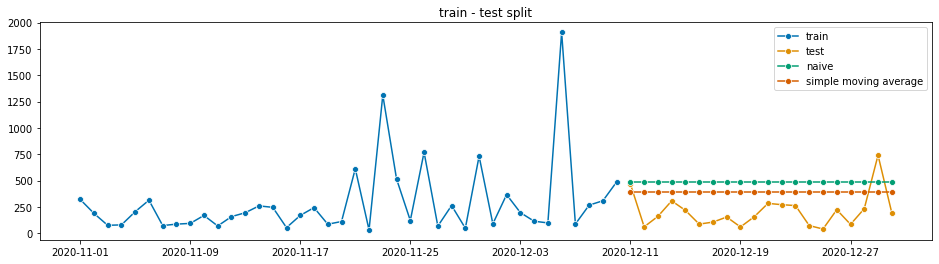

In [56]:
# temporal train test splits
naive_fcaster = NaiveForecaster(strategy="last", sp=1)
sma_fcaster = NaiveForecaster(strategy="mean", sp=1, window_length=10)

# train test splits
y_train, y_test = temporal_train_test_split(synthetic_data, test_size=20)
naive_fcaster.fit(y_train)
sma_fcaster.fit(y_train)
fh = fh = np.arange(20)+1

plot_series(
    y_train.iloc[-40:],
    y_test,
    naive_fcaster.predict(fh),
    sma_fcaster.predict(fh),
    labels = ["train", "test", "naive", "simple moving average"]
)
plt.title("train - test split")
plt.show()

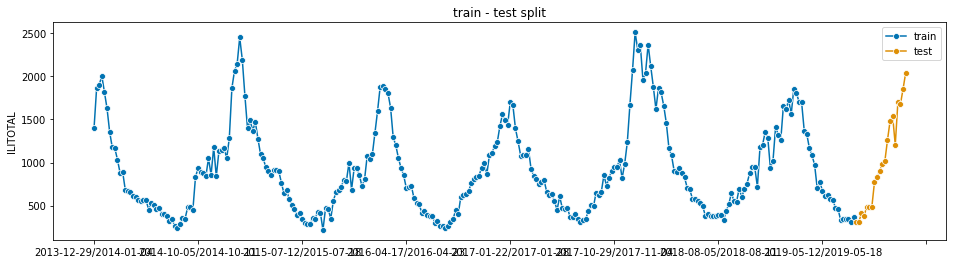

In [48]:
# train test splits
y_train, y_test = temporal_train_test_split(real_ts, test_size=20)
plot_series(
    y_train,
    
    y_test,
    labels = ["train", "test"]
)
plt.title("train - test split")
plt.show()

## Forecasting metrics

In [ ]:
# MAE
# RMSE
# MAPE
# sMAPE
# RMSSE
# MASE

## Time series cross-validation

In [ ]:
# maybe we got lucky or unlucky... 